# HW6 Spike sorting
* Read this page: https://en.wikipedia.org/wiki/Spike_sorting#:~:targetText=Spike%20sorting%20is%20a%20class,neurons%20from%20background%20electrical%20noise. 
* Use dimensionality reduction techniques and clustering algorithms to identify groups of similar spikes
* For instance: 
    * TRY DIFFERENT THRESHOLDS TO EXTRACT SPIKES (change tf parameter)
    * DO PCA
    * DO KMEANs
    * Visualize average waveform associated to each spike: 
        * plt.plot(mean(waveform[labels==0], axis=0))
        
* How many waveforms (neurons/units) are there?
* Plot the clustering result against the first 2 principal components
* Plot the average waveform of each neuron overlaid

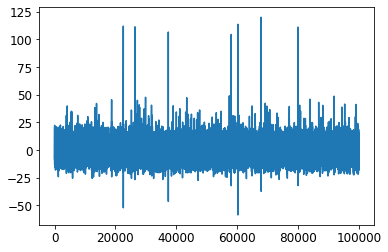

In [5]:
import numpy as np
#import pylab as plt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import os

np.random.seed(42)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

trace = np.load('spike_sort/simulation_1.npy')
plt.plot(trace[:100000])
plt.show()

In [6]:
 stats.median_absolute_deviation(trace) #meadian absolute devition

7.102276499403769

In [7]:
def get_spikes(data, spike_window=80, tf=5, offset=10, max_thresh=350):
    # extract spike waveforms
    # Calculate threshold based on data mean
    thresh = np.mean(np.abs(data)) *tf
    #thresh = stats.median_absolute_deviation(trace)

    # Find positions wherere the threshold is crossed
    pos = np.where(data > thresh)[0]
    pos = pos[pos > spike_window]

    # Extract potential spikes and align them to the maximum
    spike_samp = []
    wave_form = np.empty([1, spike_window*2])
    for i in pos:
        if i < data.shape[0] - (spike_window+1):
            # Data from position where threshold is crossed to end of window
            tmp_waveform = data[i:i+spike_window*2]

            # Check if data in window is below upper threshold (artifact rejection)
            if np.max(tmp_waveform) < max_thresh:
                # Find sample with maximum data point in window
                tmp_samp = np.argmax(tmp_waveform) +i

                # Re-center window on maximum sample and shift it by offset
                tmp_waveform = data[tmp_samp-(spike_window-offset):tmp_samp+(spike_window+offset)]
                
                #if np.max(tmp_waveform) < max_thresh:
                # Append data
                spike_samp = np.append(spike_samp, tmp_samp)
                wave_form = np.append(wave_form, tmp_waveform.reshape(1, spike_window*2), axis=0)

    # Remove duplicates
    ind = np.where(np.diff(spike_samp) > 1)[0]
    spike_samp = spike_samp[ind]
    wave_form = wave_form[ind]

    return spike_samp, wave_form

In [8]:
spike_samp, wave_form = get_spikes(trace, tf=3.9)

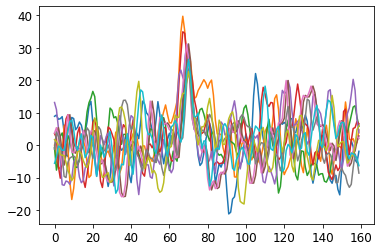

In [9]:
plt.plot(wave_form[:10].T)

In [10]:
wave_form.shape

(3615, 160)

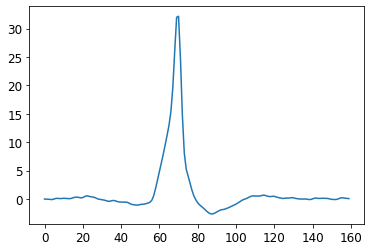

In [11]:
plt.plot(wave_form[:].mean(axis=0))

In [12]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [13]:
from sklearn.decomposition import PCA

pca2 = PCA(n_components = 2)
X2D = pca2.fit_transform(wave_form)

In [14]:
X2D.shape

(3615, 2)

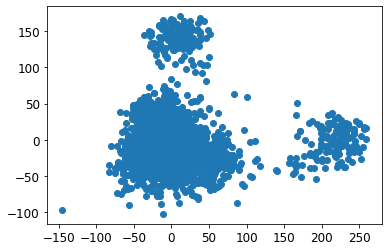

In [15]:
plt.scatter(X2D[:,0],X2D[:,1])

In [16]:
pca2.explained_variance_ratio_

array([0.20643168, 0.11321441])

In [17]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
y_pred = kmeans.fit_predict(X2D)


(array([ 718.,    0., 1193.,    0.,    0.,  148.,    0.,  166.,    0.,
        1390.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

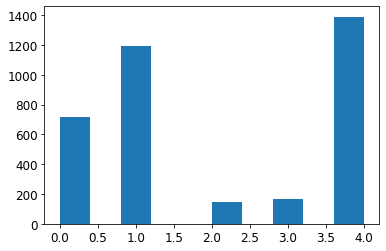

In [18]:
plt.hist(y_pred)


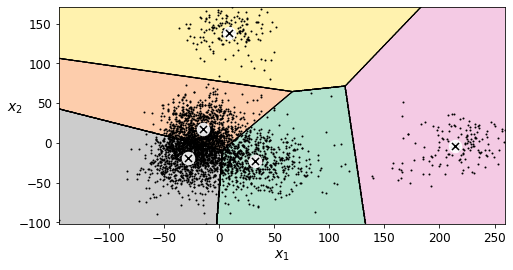

In [19]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X2D)
plt.show()
# dimensionality reduction technique!

<Figure size 1440x720 with 0 Axes>

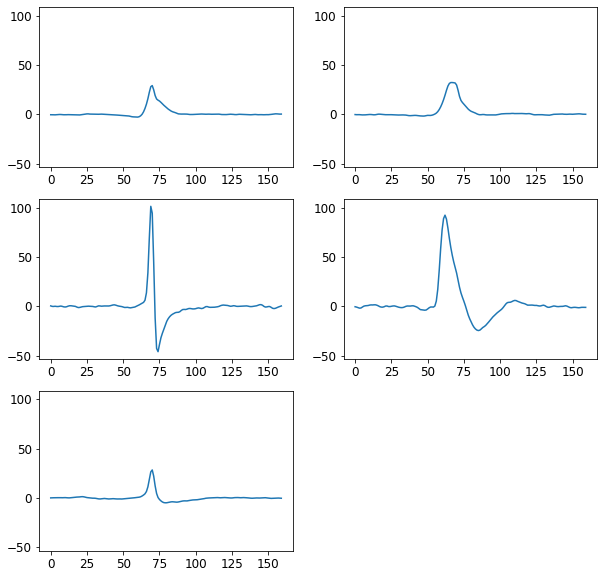

<Figure size 1440x720 with 0 Axes>

In [20]:
#PCA
pca = PCA(n_components = 100)
XD = pca.fit_transform(wave_form)

#K-means
km=5
kmeansm = KMeans(n_clusters=km, init="k-means++", random_state=42)
y_predm = kmeansm.fit_predict(XD)

#Recover data
X_inv = pca.inverse_transform(XD)

plt.figure(figsize=(10,10))
ax1=plt.subplot(np.ceil(km/2), 2, 1)
plt.plot(np.mean(X_inv[y_pred==0], axis=0))

for i in range(km):
    plt.subplot(np.ceil(km/2), 2, i+1, sharey=ax1)
    plt.plot(np.mean(X_inv[y_predm==i], axis=0))


plt.figure(figsize=(20,10))

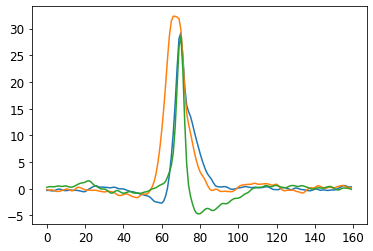

In [21]:
# small amplitude spikes
plt.plot(np.mean(X_inv[y_predm==0], axis=0))
plt.plot(np.mean(X_inv[y_predm==1], axis=0))
plt.plot(np.mean(X_inv[y_predm==4], axis=0))

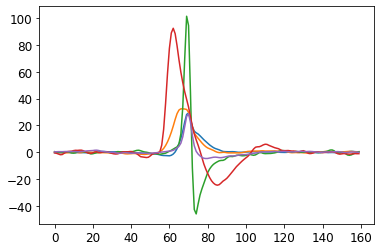

In [22]:
# mean spike overlay, all spikes
for i in range(km):
    plt.plot(np.mean(X_inv[y_predm==i], axis=0))

There seems to be 5 neurons, possibly 4

In [60]:
from sklearn.metrics import silhouette_score

score_k = []
for i in range(6):
    k = i+2 #clusters 2 to 7
    kmeans = KMeans(n_clusters=k, init="k-means++", random_state=42)
    y_pred = kmeans.fit_predict(X2D)
    score=silhouette_score (XD, y_pred)
    score_k.append(score)

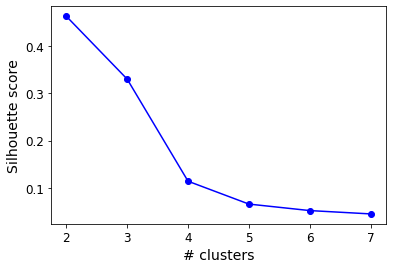

In [61]:
plt.plot([2, 3, 4, 5, 6, 7],score_k, 'bo-')
plt.xlabel('# clusters')
plt.ylabel('Silhouette score')
plt.show()